In [ ]:
INPUT Shape= 180*180
Epoch=50

In [2]:
# Importing Tools & Libraries

import os
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import  Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, f1_score, PrecisionRecallDisplay

from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize

from tensorflow.keras.metrics import Precision, Recall
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

In [3]:
# Loading Dataset and Define the Path
data_dir = '/kaggle/input/custom-uwod/DataSet_5(Final)'

In [4]:
# Data Splitting in Validation & Test for training   also applying Data augmentation  

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=(0.7, 1.5),
    horizontal_flip=True,
    validation_split=0.2  # Use 20% of the data for validation+test
)

In [5]:
# Data augmentation is not applied to validation and test data

test_val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.5   # Splitting validation + test into 50% validation, 50% test
)

In [6]:
# Training data generator

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(180, 180),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

Found 4669 images belonging to 7 classes.


In [7]:
# Validation data generator

val_generator = test_val_datagen.flow_from_directory(
    data_dir,
    target_size=(180, 180),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 2915 images belonging to 7 classes.


In [8]:
# Test data generator

test_generator = test_val_datagen.flow_from_directory(
    data_dir,
    target_size=(180, 180),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

Found 2918 images belonging to 7 classes.


In [9]:
# Confirmation of split Samples

print(f"Training samples: {len(train_generator.filenames)}")
print(f"Validation samples: {len(val_generator.filenames)}")
print(f"Test samples: {len(test_generator.filenames)}")

Training samples: 4669
Validation samples: 2915
Test samples: 2918


In [10]:
# Define Fine Tuned CNN Architecture 

model = Sequential([

    Conv2D(140, (3, 3), activation='relu', strides=1, padding='same', input_shape=(180, 180, 3)),
    MaxPooling2D((2, 2)),

    Conv2D(124, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    

    Conv2D(44, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(380, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(460, activation='relu'),
    (Dropout(0.2)),

    Dense(56, activation='relu'),

    Dense(188, activation='relu'),

# Output layer with softmax activation for classification

    Dense(7, activation='softmax') 
])


learning_rate = 0.0003102     #  We Can Adjust this value for Adam Learning rate
optimizer = Adam(learning_rate=learning_rate)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 180, 180, 140)  │         3,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 140)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 88, 88, 124)    │       156,364 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 44, 44, 124)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 42, 42, 44)     │        49,148 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 21, 21, 44)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 19, 19, 380)    │       150,860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 380)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30780)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 460)            │    14,159,260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 460)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 56)             │        25,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 188)            │        10,716 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │         1,323 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,557,407 (55.53 MB)

 Trainable params: 14,557,407 (55.53 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.n // val_generator.batch_size,
    epochs=50
)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/145 ━━━━━━━━━━━━━━━━━━━━ 57:10 24s/step - accuracy: 0.4062 - loss: 1.9335

I0000 00:00:1718746558.627665    1012 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1718746558.647497    1012 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 51/145 ━━━━━━━━━━━━━━━━━━━━ 1:21 862ms/step - accuracy: 0.3686 - loss: 1.7745

W0000 00:00:1718746601.743517    1010 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step - accuracy: 0.3835 - loss: 1.6408

W0000 00:00:1718746630.767700    1012 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


145/145 ━━━━━━━━━━━━━━━━━━━━ 101s 538ms/step - accuracy: 0.3836 - loss: 1.6401 - val_accuracy: 0.4451 - val_loss: 1.3129
Epoch 2/50
  1/145 ━━━━━━━━━━━━━━━━━━━━ 14s 101ms/step - accuracy: 0.6562 - loss: 1.0980

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6562 - loss: 1.0980 - val_accuracy: 0.3333 - val_loss: 1.3740
Epoch 3/50


W0000 00:00:1718746638.182131    1011 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


145/145 ━━━━━━━━━━━━━━━━━━━━ 49s 322ms/step - accuracy: 0.4545 - loss: 1.4160 - val_accuracy: 0.5312 - val_loss: 1.1766
Epoch 4/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 125us/step - accuracy: 0.4062 - loss: 1.3928 - val_accuracy: 0.3333 - val_loss: 2.5433
Epoch 5/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 49s 321ms/step - accuracy: 0.5038 - loss: 1.3249 - val_accuracy: 0.5701 - val_loss: 1.1359
Epoch 6/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 109us/step - accuracy: 0.4062 - loss: 1.5316 - val_accuracy: 0.6667 - val_loss: 1.0475
Epoch 7/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 49s 319ms/step - accuracy: 0.5226 - loss: 1.2540 - val_accuracy: 0.6006 - val_loss: 1.0687
Epoch 8/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 125us/step - accuracy: 0.6250 - loss: 1.1088 - val_accuracy: 1.0000 - val_loss: 0.1877
Epoch 9/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 49s 322ms/step - accuracy: 0.5632 - loss: 1.1746 - val_accuracy: 0.6209 - val_loss: 0.9888
Epoch 10/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 147us/step - accuracy: 0.6250 - loss: 0.9729 - val_ac

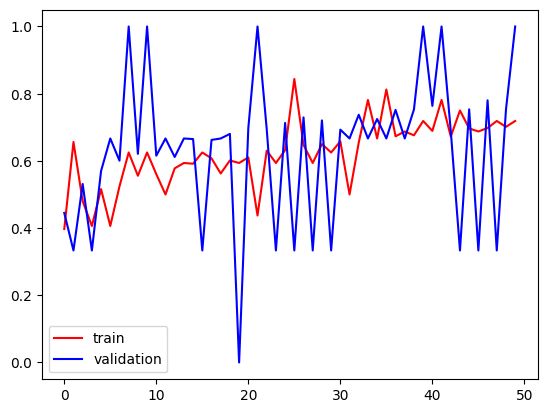

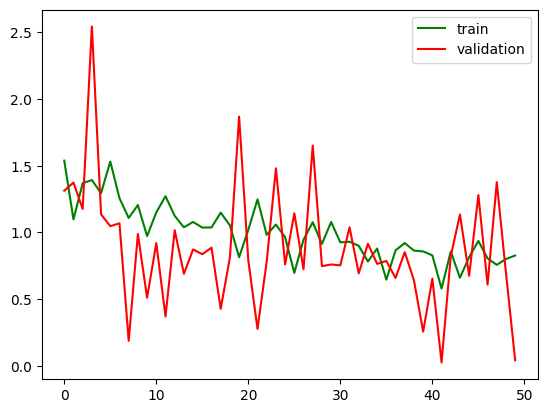

In [14]:
# Ploting Val_Accuracy & Val_Loss Graph

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()


plt.plot(history.history['loss'],color='Green',label='train')
plt.plot(history.history['val_loss'],color='red',label='validation')
plt.legend()
plt.show()

In [15]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.n // test_generator.batch_size + 1)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - accuracy: 0.7136 - loss: 0.8050
Test loss: 0.8209367990493774
Test accuracy: 0.710760772228241


W0000 00:00:1718747873.745063    1011 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [16]:
# Printing Classification Report

test_generator.reset()
preds = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
y_pred = np.argmax(preds, axis=1)
y_true = test_generator.classes

print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

 4/92 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step 

W0000 00:00:1718747874.445742    1012 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step
                 precision    recall  f1-score   support

        Dolphin       0.12      0.13      0.12       391
     Jelly Fish       0.14      0.13      0.13       423
        Octopus       0.15      0.06      0.09       281
    Sea Urchins       0.10      0.16      0.12       290
         Sharks       0.05      0.03      0.04       295
Turtle_Tortoise       0.32      0.35      0.33       952
          Whale       0.10      0.12      0.11       286

       accuracy                           0.19      2918
      macro avg       0.14      0.14      0.13      2918
   weighted avg       0.18      0.19      0.18      2918



W0000 00:00:1718747880.169471    1013 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


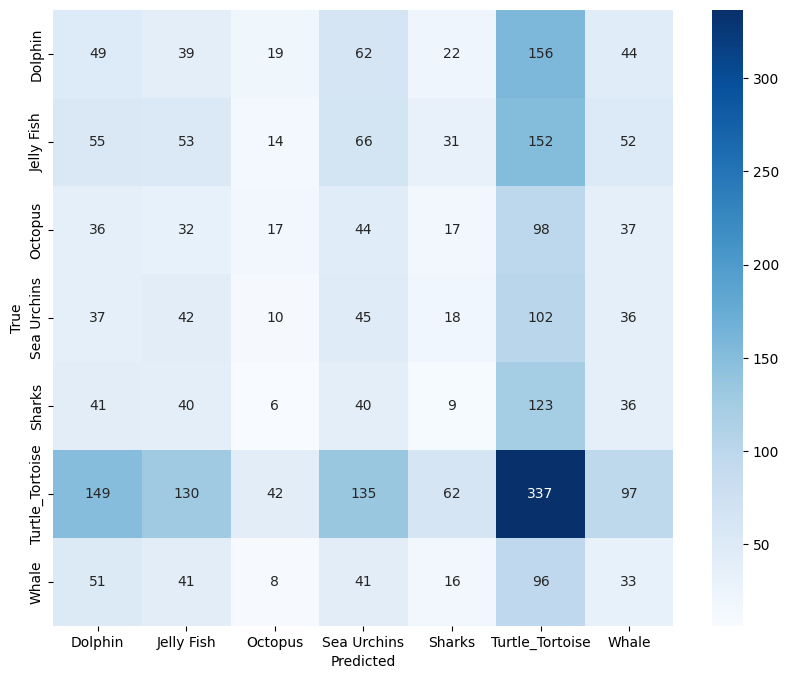

In [17]:
# Plotting Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [18]:
# Printing precision, Recall, F1 score

precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Precision: 0.17871564531608658
Recall: 0.18608636052090474
F1 Score: 0.1794204966906271


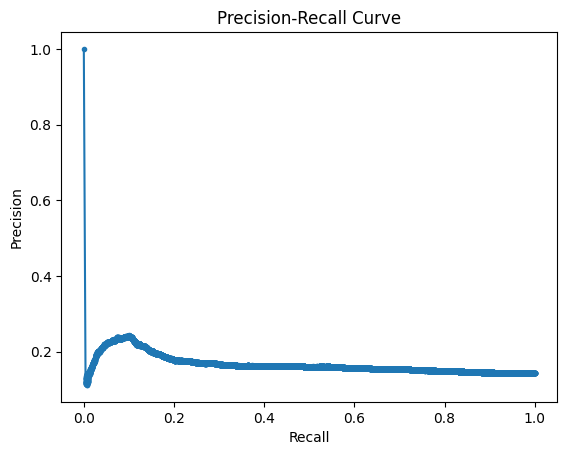

In [19]:
# Plot precision-recall curve
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize

# Binarize the output for precision-recall curve
y_test_bin = label_binarize(y_true, classes=list(test_generator.class_indices.values()))
y_score_bin = preds

precision_curve, recall_curve, _ = precision_recall_curve(y_test_bin.ravel(), y_score_bin.ravel())

plt.figure()
plt.plot(recall_curve, precision_curve, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

In [20]:
# Save the VGG16 model
model.save('CACNN_CDS(71.07%).h5')

In [ ]:
history = model.fit(train_generator, epochs=1, validation_data=val_generator)